In [1]:
import os
import pandas as pd
import numpy as np
import sys
from time import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, Flatten
from keras.callbacks import TensorBoard
from keras.optimizers import RMSprop
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.utils import np_utils

from keras import backend as K
K.set_image_dim_ordering('tf')
import matplotlib.pyplot as plt
import itertools
from keras.regularizers import L1L2

import numpy as np
import pandas as pd
np.random.seed(10)

from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import Adagrad
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
from sklearn import manifold
import keras.layers.normalization as bn

from sklearn.metrics import confusion_matrix
from confusion_matrix_pretty_print import _test_data_class
from sklearn.utils import shuffle

from sklearn.preprocessing import normalize  
from sklearn.preprocessing import normalize  
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import classification_report
from keras import regularizers

%matplotlib inline

Using TensorFlow backend.


In [2]:
def prepareData(classification_type): 
    df = pd.read_csv("all_gene_input_data.csv", sep='\t')
    
    df = df.drop(df.columns[[0]], axis=1)
    
    if classification_type =='type':
        df = df[df['ctype'] != 15]
        for val in range(1, np.unique(df['ctype']).size + 1):
            df.ix[df['ctype'] == val, 'ctype'] = val - 1  # labels needs to start from 0
    
    if classification_type =='identification':
        df.ix[df['ctype'] != 15, 'ctype'] = 0
        df.ix[df['ctype'] == 15, 'ctype'] = 1

    column_headers = df.columns.values.tolist()
    column_headers.remove('ctype')
    
    features = df[column_headers].values
    labels = df['ctype'].values   

    normalizedFeatures = normalize(features.reshape(features.shape[0],-1), norm='max', axis=0).reshape(features.shape)
   
  
    print(type(normalizedFeatures))
    print(type(labels))

    #features = binary[cols]
    #labels = binary['ctype']

    features = np.array(normalizedFeatures)
    labels = np.array(labels)

    print(features.shape)
    print(labels.shape)

    #print(images.shape)
    features, labels = shuffle(features, labels, random_state = 0)  # shuffle the data
    print("Shauffle completed!")
    
    return features, labels

In [3]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [4]:
def prepare_test_train_valid(features, labels):
    train_x, test_x, train_y, test_y = train_test_split(features, labels, test_size=0.80, random_state=12345)
    test_x, valid_x, test_y, valid_y = train_test_split(train_x, train_y, test_size=0.20, random_state=12345)
    
    print('X_train shape:', train_x.shape)
    print('Y_train shape:', train_y.shape)
    
    train_x = np.reshape(train_x,(train_x.shape[0], 1, train_x.shape[1]))
    test_x = np.reshape(test_x,(test_x.shape[0], 1, test_x.shape[1]))
    valid_x = np.reshape(valid_x,(valid_x.shape[0], 1, valid_x.shape[1]))
    
    return train_x, test_x, train_y, test_y, valid_x, valid_y

In [5]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [15]:
def model_build(num_classes, timesteps, data_dim, reg): #OK
    # expected input data shape: (batch_size, timesteps, data_dim)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(timesteps, data_dim), recurrent_regularizer= reg)) 
    model.add(Dropout(0.70))

    #model.add(LSTM(64, return_sequences=True))
    #model.add(Dropout(0.50))
    
    # apply softmax to output
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [7]:
def model_train(model, number_epoch, train_x, train_y, valid_x, valid_y, classification_type):   
    sgd = Adagrad(lr=0.01, epsilon=None, decay=0.0)

    # a stopping function should the validation loss stop improving
    #earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    
    if classification_type == 'type':
        loss = 'categorical_crossentropy'
    
    else:
        loss = 'binary_crossentropy'

    model.compile(loss=loss, metrics=['accuracy'], optimizer=sgd)
    tensorboardRNN = TensorBoard(log_dir="RNN_logs/{}".format(time()))
    
    #for i in range(number_epoch):
    history1 = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[tensorboardRNN], batch_size=32, epochs=int(number_epoch), shuffle=False)
    #model.reset_states()        
    
    print(model.summary())

    return model, history1

In [8]:
def plotLoses(history1, number_opoch): 
    # visualizing losses and accuracy 
    train_loss = history1.history['loss']
    val_loss   = history1.history['val_loss']
    train_acc  = history1.history['acc']
    val_acc    = history1.history['val_acc']
    xc         = range(number_opoch)
   
    plt.plot(xc, train_loss, 'r--', label='Traing loss per epoch', linewidth=1.0)
    plt.title('Training and validation loss per epoch')
    #plt.xlabel('Epoch')
    #plt.ylabel('Traing loss')
    #plt.legend(loc='upper right')
    #plt.grid(True)
    
    plt.plot(xc, val_loss, 'c--', label='Validation loss per epoch', linewidth=1.0)
    #plt.title('Validation loss per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    #plt.grid(True)
    plt.show()
    
    plt.plot(xc, train_acc, 'r--', label='Training accuracy per epoch', linewidth=1.0)
    plt.title('Training vs validation accuracy per epoch')
    #plt.xlabel('Epoch')
    #plt.ylabel('Traing loss')
    #plt.legend(loc='upper right')
    #plt.grid(True)
    
    plt.plot(xc, val_acc, 'c--', label='Validation accuracy per epoch', linewidth=1.0)
    #plt.title('Validation loss per epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper right')
    #plt.grid(True)

In [9]:
def model_evaluate(rnn_model, classification_type, test_x, test_y):
            
    y_prob = rnn_model.predict(test_x) 
    #rnn_model.reset_states()  
    
    y_pred = y_prob.argmax(axis=-1)
    y_true = np.argmax(test_y, 1)

    # evaluate the model
    score, accuracy = rnn_model.evaluate(test_x, test_y, batch_size=32)
    #rnn_model.reset_states()
    
    print("Accuracy = {:.2f}".format(accuracy))
    print("Score = {:.2f}".format(score))

    # the F-score gives a similiar value to the accuracy score, but useful for cross-checking
    if classification_type == 'type':
        p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
        
        print ("F-Score:", round(f,3))
        print ("Precision:", round(p,3))
        print ("Recall:", round(r,3))
        print ("F-Score:", round(f,3)) 
        
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_true, y_pred)
        np.set_printoptions(precision=2)
        
        class_names = ["COAD", "GBM", "KIRC", "LGG", "LUAD", "LUSC", "OV", "UCEC", "BRCA", "HNSC","THCA", "PRAD", "STAD", "BLCA"]
        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix: true vs predicted label')  
        plt.show() 
    
        _test_data_class(y_true, y_pred, class_names)
        import gc; gc.collect()
    
        print(classification_report(y_true, y_pred, target_names=class_names))
    
    else:
        auc = metrics.roc_auc_score(y_true, y_pred)  # Receiver operating characteristic curve a.k.a ROC is a graphic plot illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.      
        # 
        mcc = matthews_corrcoef(y_true, y_pred)
        
        print ("Area under ROC Curve:", round(auc,3))
        print ("Matthews correlation coefficient:", round(mcc,3)) # +1 means perfect prediction
        
        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_true, y_pred)
        np.set_printoptions(precision=2)
        
        class_names = ["Healthy", "Tumor"]

        # Plot non-normalized confusion matrix
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix: true vs predicted label')  
        plt.show() 
    
        _test_data_class(y_true, y_pred, class_names)
        import gc; gc.collect()    

        print(classification_report(y_true, y_pred, target_names=class_names))

In [10]:
type_features, type_labels = prepareData('type')
risk_features, risk_labels = prepareData('identification')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(7895, 20308)
(7895,)
Shauffle completed!


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(15699, 20308)
(15699,)
Shauffle completed!


In [11]:
def cancerClassifier(classification_type, number_epoch, features, labels, reg):

    #features, labels = prepareData(classification_type)

    labels = one_hot_encode(labels)
    train_x, test_x, train_y, test_y, valid_x, valid_y = prepare_test_train_valid(features, labels)

    data_dim = 20308
    print(data_dim)

    timesteps = 1
    num_classes = train_y.shape[1]
    print(num_classes)

    model = model_build(num_classes, timesteps, data_dim, reg)

    trainedModel, history1 = model_train(model, number_epoch, train_x, train_y, valid_x, valid_y, classification_type)
    plotLoses(history1, number_epoch)
    model_evaluate(trainedModel, classification_type, test_x, test_y) 
    
    #return trainedModel, model

X_train shape: (2511, 20308)
Y_train shape: (2511, 2)
20308
2
Train on 2511 samples, validate on 628 samples
Epoch 1/100
2511/2511 [==============================] - 26s 10ms/step - loss: 22.7381 - acc: 0.9036 - val_loss: 4.0413 - val_acc: 0.9140
Epoch 2/100
2511/2511 [==============================] - 25s 10ms/step - loss: 3.2026 - acc: 0.9391 - val_loss: 2.7398 - val_acc: 0.9140
Epoch 3/100
2511/2511 [==============================] - 25s 10ms/step - loss: 2.1758 - acc: 0.9526 - val_loss: 1.9745 - val_acc: 0.9124
Epoch 4/100
2511/2511 [==============================] - 26s 10ms/step - loss: 1.3748 - acc: 0.9721 - val_loss: 1.2284 - val_acc: 0.9076
Epoch 5/100
2511/2511 [==============================] - 26s 10ms/step - loss: 0.8916 - acc: 0.9813 - val_loss: 1.0211 - val_acc: 0.9061
Epoch 6/100
2511/2511 [==============================] - 26s 10ms/step - loss: 0.4182 - acc: 0.9892 - val_loss: 0.7831 - val_acc: 0.9061
Epoch 7/100
2511/2511 [==============================] - 26s 10ms/st

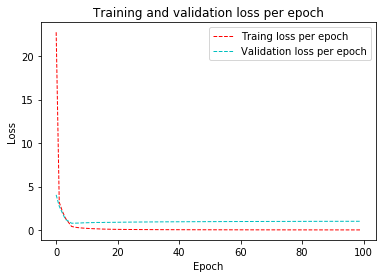

12560/12560 [==============================] - 23s 2ms/step
Accuracy = 0.89
Score = 1.02
Area under ROC Curve: 0.894
Matthews correlation coefficient: 0.789
Confusion matrix, without normalization
[[5522  778]
 [ 552 5708]]


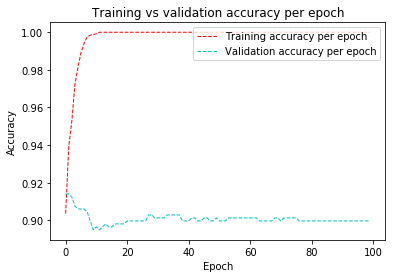

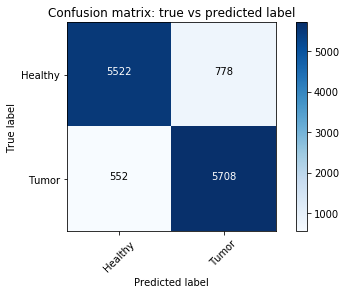

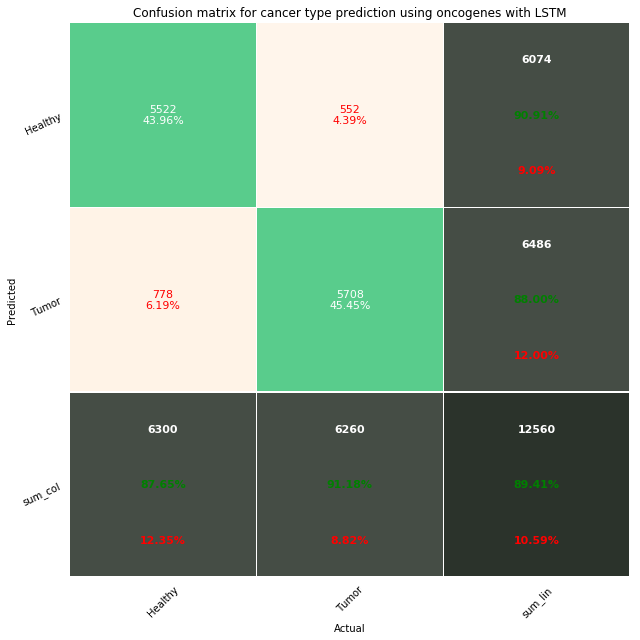

             precision    recall  f1-score   support

    Healthy       0.91      0.88      0.89      6300
      Tumor       0.88      0.91      0.90      6260

avg / total       0.89      0.89      0.89     12560



In [17]:
#cancerClassifier('type', 50, type_features, type_labels)
reg = L1L2(l1=0.10, l2=0.00)
cancerClassifier('identification', 100, risk_features, risk_labels, reg)

X_train shape: (1579, 20308)
Y_train shape: (1579, 14)
20308
14
Train on 1579 samples, validate on 316 samples
Epoch 1/2
1579/1579 [==============================] - 17s 11ms/step - loss: 36.8271 - acc: 0.5275 - val_loss: 5.8232 - val_acc: 0.8038
Epoch 2/2
1579/1579 [==============================] - 17s 11ms/step - loss: 4.8095 - acc: 0.7733 - val_loss: 3.7592 - val_acc: 0.8829
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 1, 128)            10463744  
_________________________________________________________________
dropout_20 (Dropout)         (None, 1, 128)            0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 14)                1806      
Total params: 10,465,550

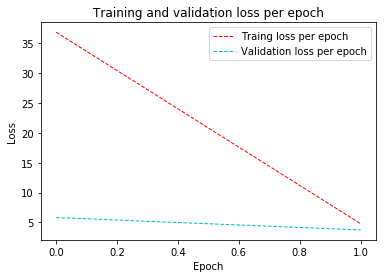

1263/1263 [==============================] - 5s 4ms/step
Accuracy = 0.88
Score = 3.77
F-Score: 0.882
Precision: 0.882
Recall: 0.882
F-Score: 0.882
Confusion matrix, without normalization
[[ 65   0   0   2   0   1   0   0   1   0   2   2   4   1]
 [  0  84   1   3   0   0   0   0   0   1   2   2   0   0]
 [  1   1  93   0   0   0   0   0   0   0   3   4   0   0]
 [  0   8   1  82   0   0   0   0   1   0   3   2   0   0]
 [  0   1   0   0  52   2   0   1   2   2   3   1   1   0]
 [  0   0   0   0   0  77   0   0   0   0   2   1   0   0]
 [  0   0   0   0   0   0  87   2   2   0   0   0   0   0]
 [  0   0   0   0   0   2   1  84   1   0  11   0   0   0]
 [  0   0   1   0   0   1   1   0 153   1   8   0   0   0]
 [  0   0   1   0   1   4   1   0   2  72   2   7   0   0]
 [  0   0   0   0   0   0   0   5   0   0  70   6   0   1]
 [  0   0   0   0   0   0   0   0   1   0   0  80   0   0]
 [  0   0   0   1   0   0   0   4   0   1   8   2  57   0]
 [  1   0   0   0   1   2   0   1   0   0   2 

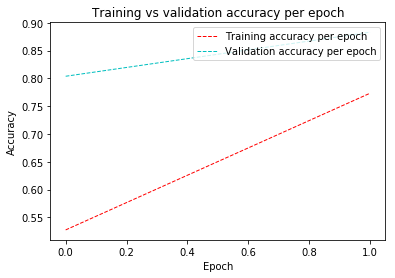

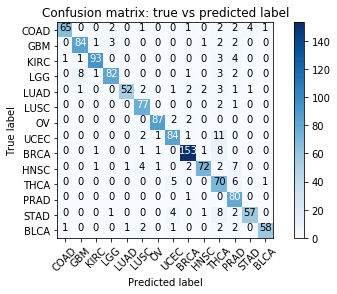

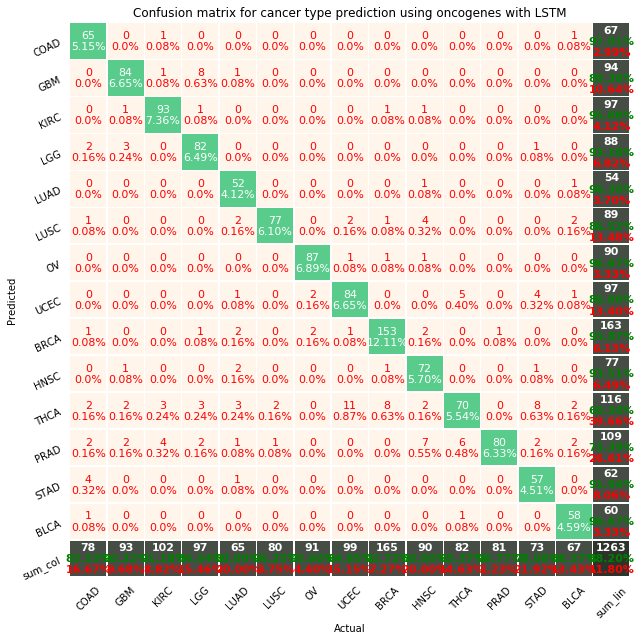

             precision    recall  f1-score   support

       COAD       0.97      0.83      0.90        78
        GBM       0.89      0.90      0.90        93
       KIRC       0.96      0.91      0.93       102
        LGG       0.93      0.85      0.89        97
       LUAD       0.96      0.80      0.87        65
       LUSC       0.87      0.96      0.91        80
         OV       0.97      0.96      0.96        91
       UCEC       0.87      0.85      0.86        99
       BRCA       0.94      0.93      0.93       165
       HNSC       0.94      0.80      0.86        90
       THCA       0.60      0.85      0.71        82
       PRAD       0.73      0.99      0.84        81
       STAD       0.92      0.78      0.84        73
       BLCA       0.97      0.87      0.91        67

avg / total       0.90      0.88      0.88      1263



In [34]:
reg = L1L2(l1=0.10, l2=0.10)
cancerClassifier('type', 2, type_features, type_labels, reg)

X_train shape: (1579, 20308)
Y_train shape: (1579, 14)
20308
14
Train on 1579 samples, validate on 316 samples
Epoch 1/1
1579/1579 [==============================] - 24s 15ms/step - loss: 36.8273 - acc: 0.5193 - val_loss: 5.8244 - val_acc: 0.8070
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 128)            10463744  
_________________________________________________________________
dropout_3 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 14)                1806      
Total params: 10,465,550
Trainable params: 10,465,550
Non-trainable params: 0
_________________________________________________________________
None


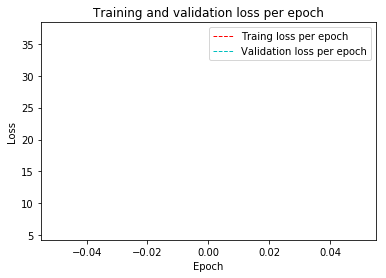

1263/1263 [==============================] - 4s 3ms/step
Accuracy = 0.79
Score = 5.84
F-Score: 0.793
Precision: 0.793
Recall: 0.793
F-Score: 0.793
Confusion matrix, without normalization
[[ 60   2   0   0   0   0   0   0   1   1   1   7   5   1]
 [  1  81   1   4   0   1   0   0   0   0   1   3   0   1]
 [  0   2  90   0   0   0   0   0   0   1   3   6   0   0]
 [  1  10   1  77   0   0   0   0   1   0   1   5   1   0]
 [  1   1   2   0  41   2   0   0   7   1   3   3   3   1]
 [  0   0   0   0   1  67   0   3   0   4   2   1   2   0]
 [  0   0   0   0   0   2  68  16   5   0   0   0   0   0]
 [  0   0   0   0   0   1   5  73   6   0  12   0   2   0]
 [  1   0   1   0   0   0   3   0 149   1   9   1   0   0]
 [  0   0   1   0   0  11   0   1   3  63   0   9   1   1]
 [  0   0   0   0   2   0   0   2   1   0  64  12   0   1]
 [  0   0   0   0   0   0   0   0   2   0   0  79   0   0]
 [  3   2   0   1   1   3   1   3   1   0   7   6  43   2]
 [  1   2   1   0   1   3   0   2   5   0   2 

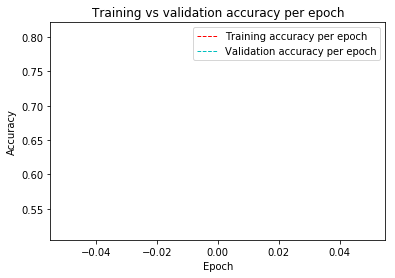

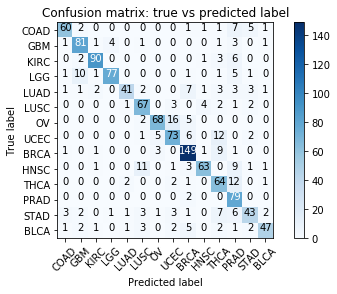

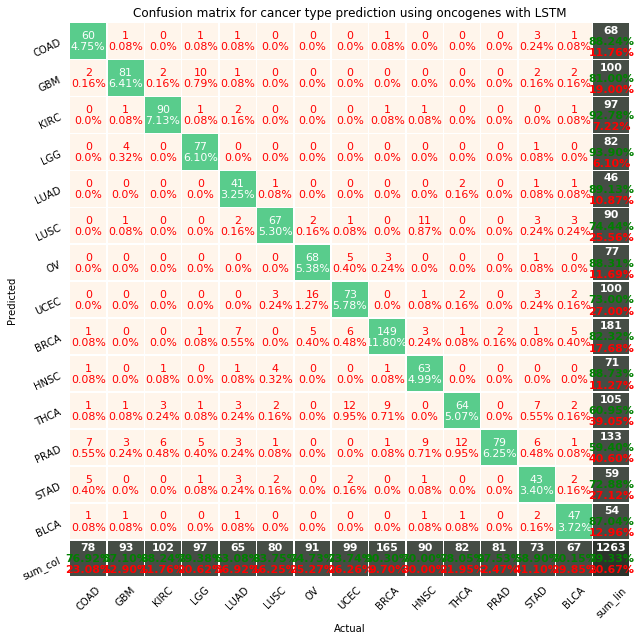

             precision    recall  f1-score   support

       COAD       0.88      0.77      0.82        78
        GBM       0.81      0.87      0.84        93
       KIRC       0.93      0.88      0.90       102
        LGG       0.94      0.79      0.86        97
       LUAD       0.89      0.63      0.74        65
       LUSC       0.74      0.84      0.79        80
         OV       0.88      0.75      0.81        91
       UCEC       0.73      0.74      0.73        99
       BRCA       0.82      0.90      0.86       165
       HNSC       0.89      0.70      0.78        90
       THCA       0.61      0.78      0.68        82
       PRAD       0.59      0.98      0.74        81
       STAD       0.73      0.59      0.65        73
       BLCA       0.87      0.70      0.78        67

avg / total       0.81      0.79      0.79      1263



In [14]:
reg = L1L2(l1=0.10, l2=0.10)

#cancerClassifier('identification', 10, risk_features, risk_labels, reg)
cancerClassifier('type',1, type_features, type_labels, reg)

X_train shape: (1579, 20308)
Y_train shape: (1579, 14)
20308
14
Train on 1579 samples, validate on 316 samples
Epoch 1/2
1579/1579 [==============================] - 24s 15ms/step - loss: 32.3018 - acc: 0.4072 - val_loss: 6.1771 - val_acc: 0.6804
Epoch 2/2
1579/1579 [==============================] - 23s 15ms/step - loss: 5.3292 - acc: 0.5845 - val_loss: 4.1823 - val_acc: 0.7595
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 1, 128)            10463744  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 14)                1806      
Total params: 10,465,550

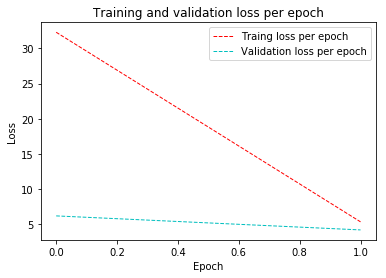

1263/1263 [==============================] - 5s 4ms/step
Accuracy = 0.76
Score = 4.19
F-Score: 0.763
Precision: 0.763
Recall: 0.763
F-Score: 0.763
Confusion matrix, without normalization
[[ 59   1   0   2   0   1   2   1   1   0   1   6   3   1]
 [  0  78   1   6   0   0   0   1   1   1   1   4   0   0]
 [  0   2  87   2   0   0   0   0   0   2   2   7   0   0]
 [  0  10   1  77   0   0   0   0   1   0   0   7   0   1]
 [  0   1   3   0  39   4   0   0  12   0   2   3   1   0]
 [  0   0   0   1   1  71   0   1   1   1   2   1   0   1]
 [  1   0   0   0   0   0  82   1   5   0   0   0   0   2]
 [  0   0   0   0   1   1  19  60  10   1   7   0   0   0]
 [  1   0   1   0   1   2   2   1 146   1   8   1   0   1]
 [  0   0   1   3   0  19   0   0   5  48   1  10   1   2]
 [  0   0   0   1   0   0   0   4   3   0  56  18   0   0]
 [  0   0   0   0   0   0   0   0   3   1   0  77   0   0]
 [  6   1   0   3   0   4   0   2   3   2   4   7  40   1]
 [  1   2   0   0   2   3   1   1   9   1   1 

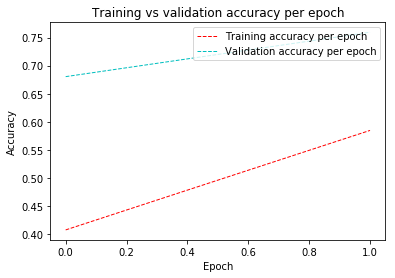

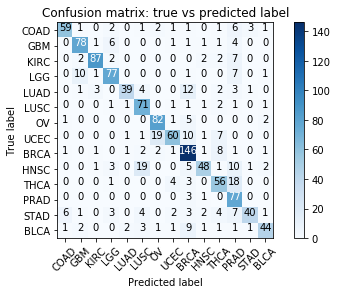

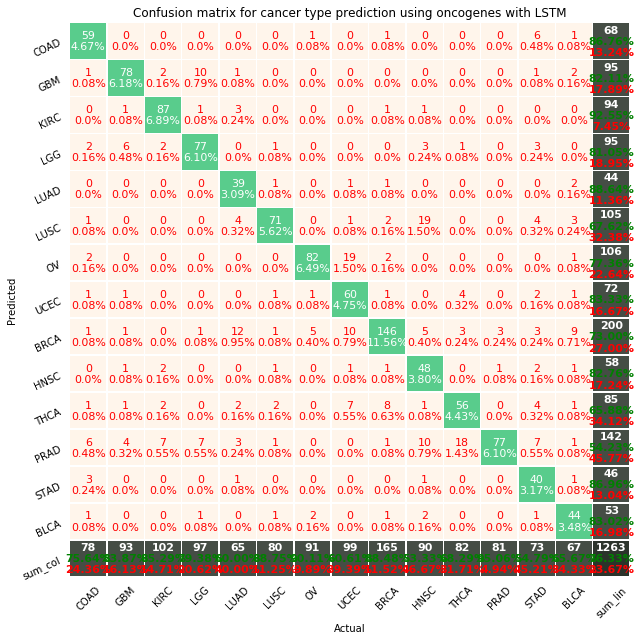

             precision    recall  f1-score   support

       COAD       0.87      0.76      0.81        78
        GBM       0.82      0.84      0.83        93
       KIRC       0.93      0.85      0.89       102
        LGG       0.81      0.79      0.80        97
       LUAD       0.89      0.60      0.72        65
       LUSC       0.68      0.89      0.77        80
         OV       0.77      0.90      0.83        91
       UCEC       0.83      0.61      0.70        99
       BRCA       0.73      0.88      0.80       165
       HNSC       0.83      0.53      0.65        90
       THCA       0.66      0.68      0.67        82
       PRAD       0.54      0.95      0.69        81
       STAD       0.87      0.55      0.67        73
       BLCA       0.83      0.66      0.73        67

avg / total       0.79      0.76      0.76      1263



In [18]:
reg = L1L2(l1=0.10, l2=0.10)

#cancerClassifier('identification', 10, risk_features, risk_labels, reg)
cancerClassifier('type',2, type_features, type_labels, reg)